In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

import numpy as np
import torchutils as tu
import matplotlib.pyplot as plt
import time
from typing import Tuple

In [2]:
!pip install torchutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
train_dataset = CIFAR10(
    root='aux/',
    download=True, 
    train=True,
    transform=T.Compose(
        [
            T.Resize((32, 32)), # на всякий случай применяем приведение к нужному размеру (тут он по умолчанию 32)
            T.ToTensor(),
            T.Normalize(
                (.5, .5, .5), (.5, .5, .5) # нормализация
            )
        ]
    )
)

valid_dataset = CIFAR10(
    root='aux/',
    download=True, 
    train=False,
    transform=T.Compose(
            [
                T.Resize((32, 32)),
                T.ToTensor(),
                T.Normalize(
                    (.5, .5, .5), (.5, .5, .5)
                )
            ]
        )
)

100%|██████████| 170498071/170498071 [00:03<00:00, 47948781.73it/s]


Extracting aux/cifar-10-python.tar.gz to aux/
Files already downloaded and verified


In [5]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset,
  batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(valid_dataset,
  batch_size=BATCH_SIZE, shuffle=True)

In [6]:
device="cuda" 

In [7]:
class BigCNNDrop(nn.Module): 
    def __init__(self): 
        super(BigCNNDrop, self).__init__() 
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, # (w - k +2*p) / s + 1
                                            out_channels=32, 
                                            kernel_size=3, 
                                            stride=1, 
                                            padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=32, # (w - k +2*p) / s + 1
                                            out_channels=64, 
                                            kernel_size=3, 
                                            stride=1, 
                                            padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2)) 

        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=64, # (w - k +2*p) / s + 1
                                            out_channels=128, 
                                            kernel_size=3, 
                                            stride=1, 
                                            padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=128, # (w - k +2*p) / s + 1
                                            out_channels=128, 
                                            kernel_size=3, 
                                            stride=1, 
                                            padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=128, # (w - k +2*p) / s + 1
                                            out_channels=256, 
                                            kernel_size=3, 
                                            stride=1, 
                                            padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=256, # (w - k +2*p) / s + 1
                                            out_channels=256, 
                                            kernel_size=3, 
                                            stride=1, 
                                            padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2)) 


        self.relu=nn.ReLU()
        self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(4096, 1024) 
        # self.fc1 = nn.LazyLinear(16)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

        
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        
        out = out.reshape(out.size(0), -1) # view flatten
        out = self.drop_out(out) 
        out = self.relu(self.fc1(out))
        out = self.drop_out(out) 
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out
        

    
model_big_drop = BigCNNDrop()
tu.get_model_summary(model_big_drop, torch.randn(BATCH_SIZE, 3, 32, 32))
optimizer = torch.optim.Adam(model_big_drop.parameters())
criterion = torch.nn.CrossEntropyLoss()

Layer                          Kernel              Output          Params             FLOPs
0_layer1.Conv2d_0            [3, 32, 3, 3]    [128, 32, 32, 32]         896     117,440,512
1_layer1.BatchNorm2d_1                [32]    [128, 32, 32, 32]          64      16,777,216
2_layer1.ReLU_2                          -    [128, 32, 32, 32]           0               0
3_layer1.Conv2d_3           [32, 64, 3, 3]    [128, 64, 32, 32]      18,496   2,424,307,712
4_layer1.ReLU_4                          -    [128, 64, 32, 32]           0               0
5_layer1.MaxPool2d_5                     -    [128, 64, 16, 16]           0               0
6_layer2.Conv2d_0          [64, 128, 3, 3]   [128, 128, 16, 16]      73,856   2,420,113,408
7_layer2.BatchNorm2d_1               [128]   [128, 128, 16, 16]         256      16,777,216
8_layer2.ReLU_2                          -   [128, 128, 16, 16]           0               0
9_layer2.Conv2d_3         [128, 128, 3, 3]   [128, 128, 16, 16]     147,584   4,

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!cd /content

In [10]:
model = BigCNNDrop()
model.load_state_dict(torch.load('drive/MyDrive/Colab Notebooks/model_big_drop.py'))
model.eval()

BigCNNDrop(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Con

# Новый раздел

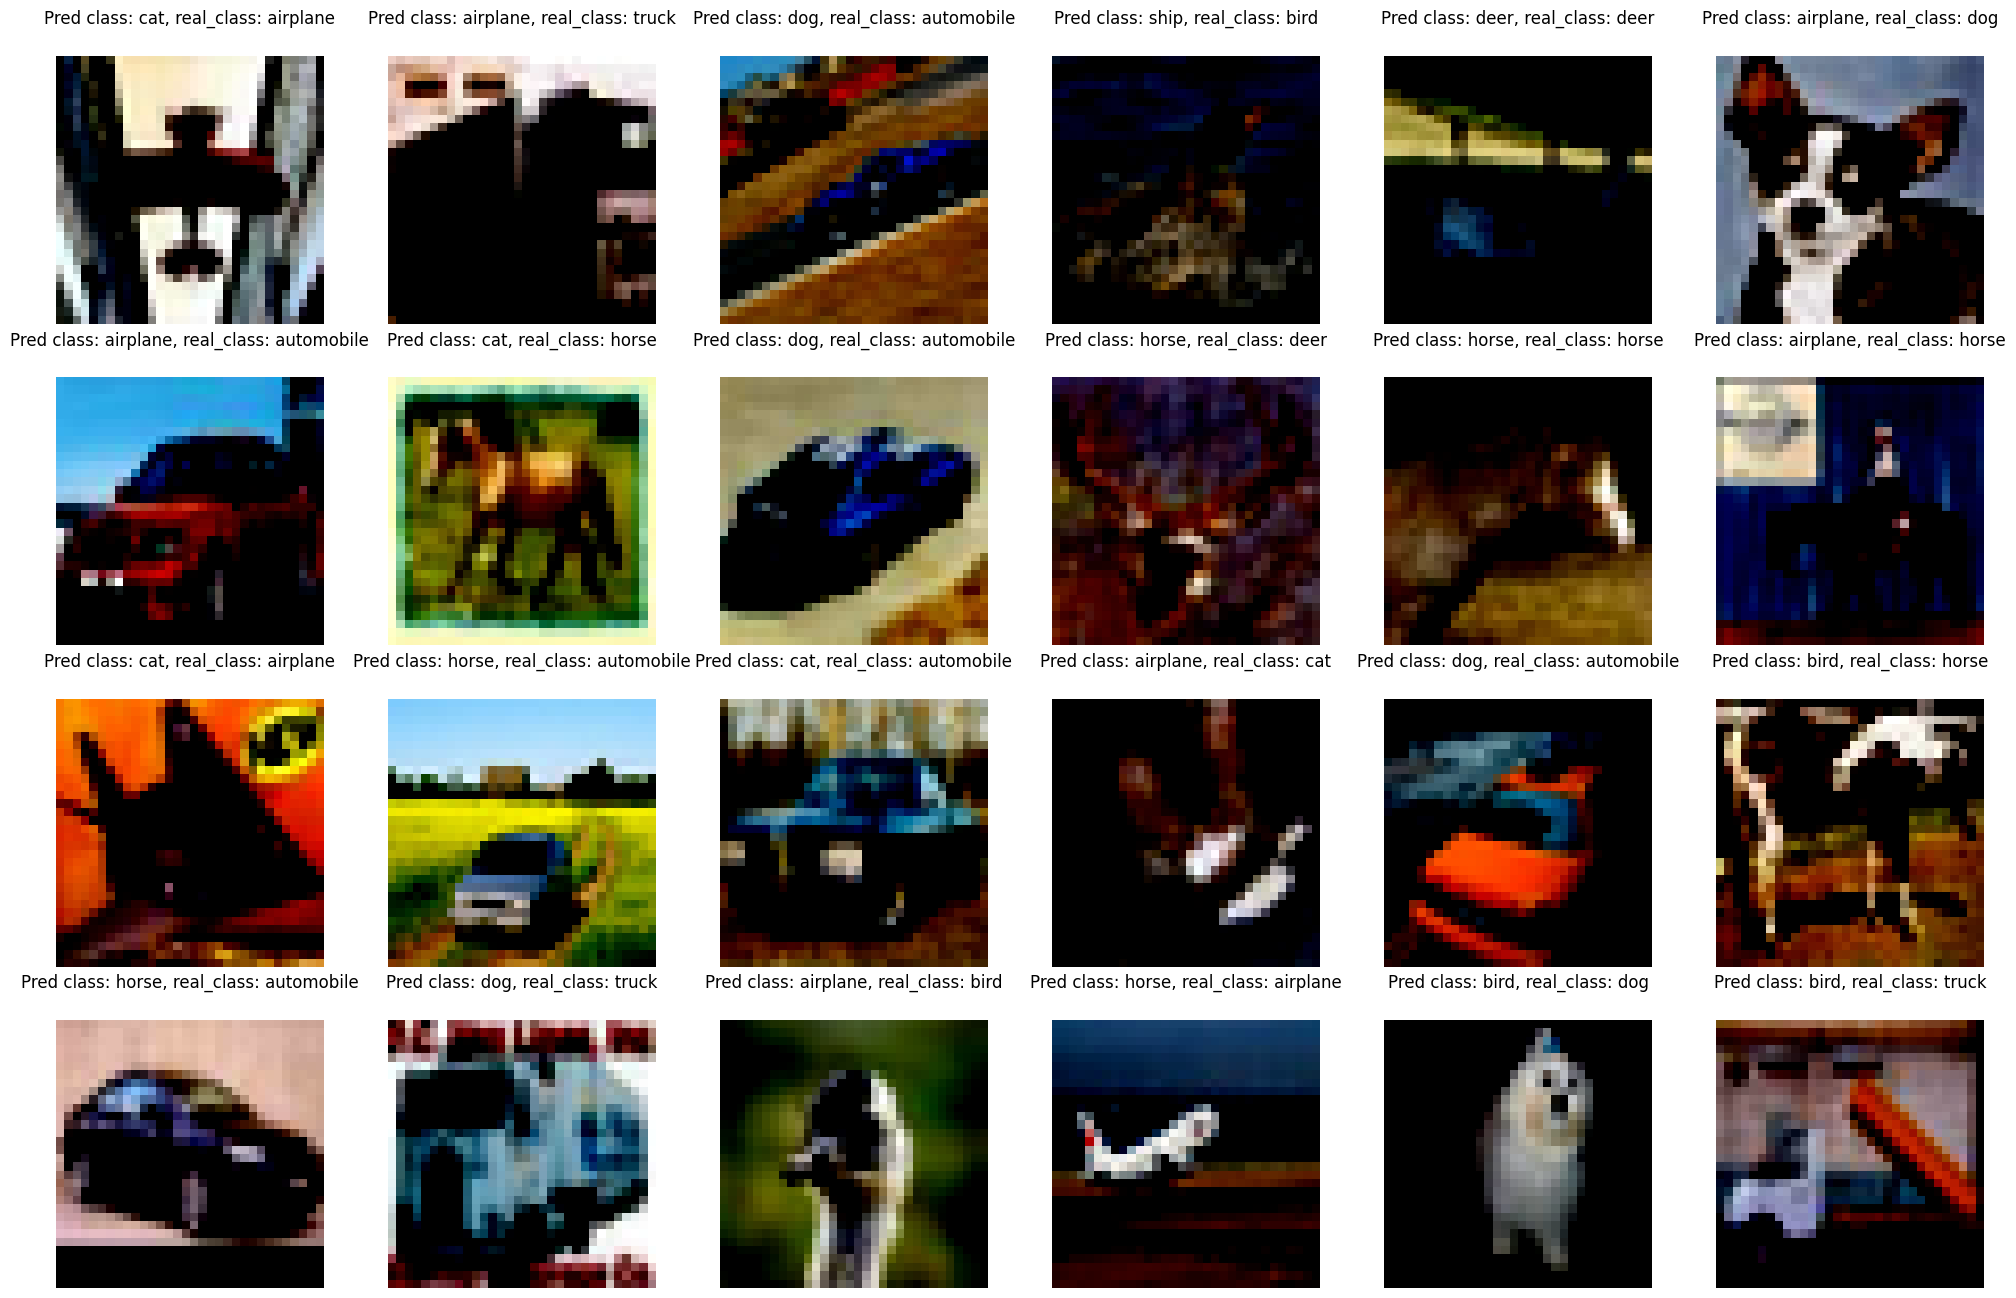

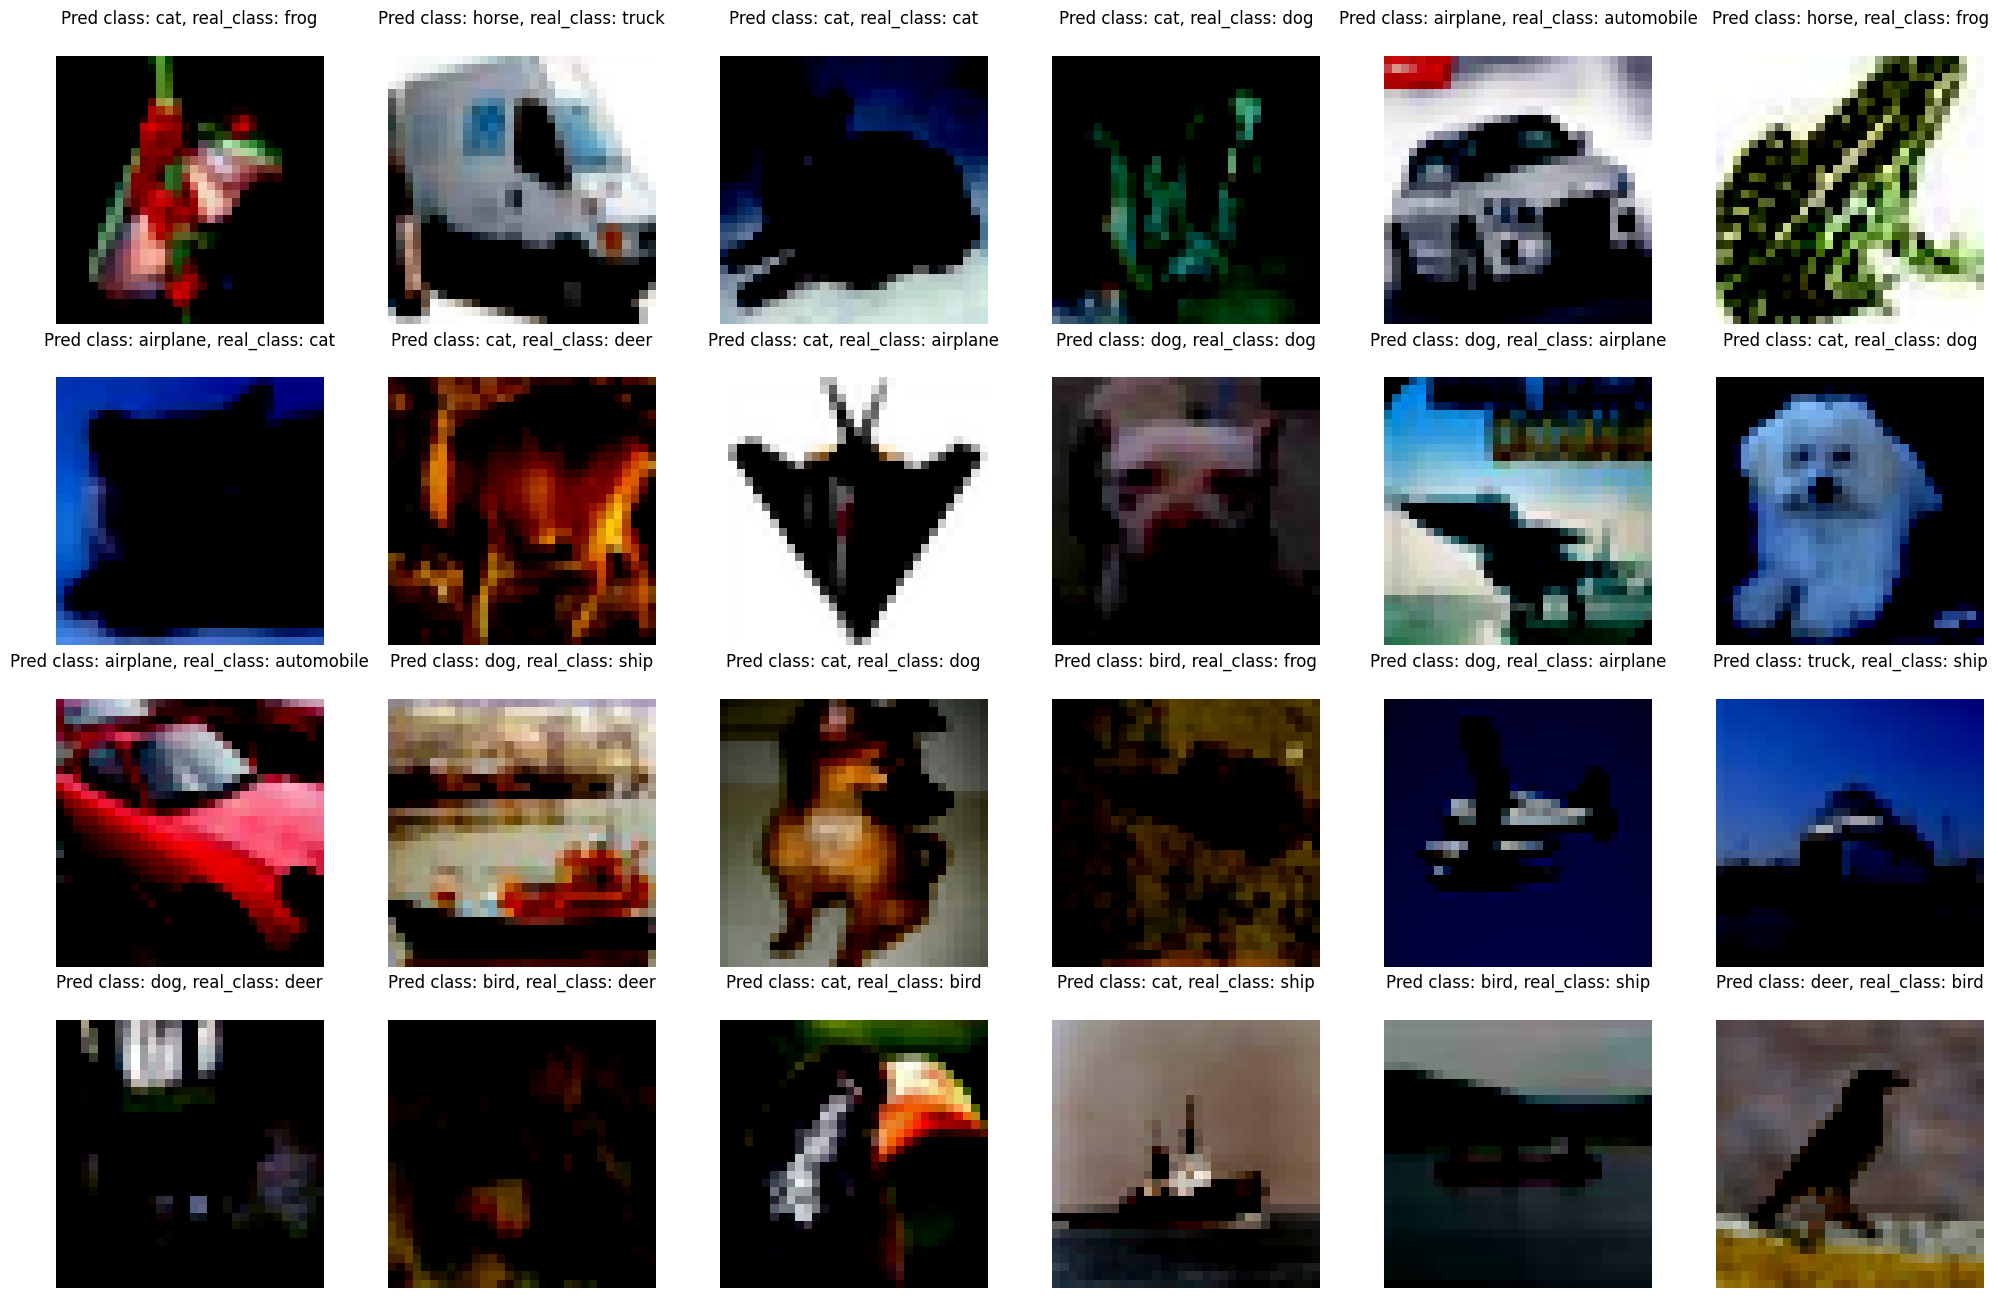

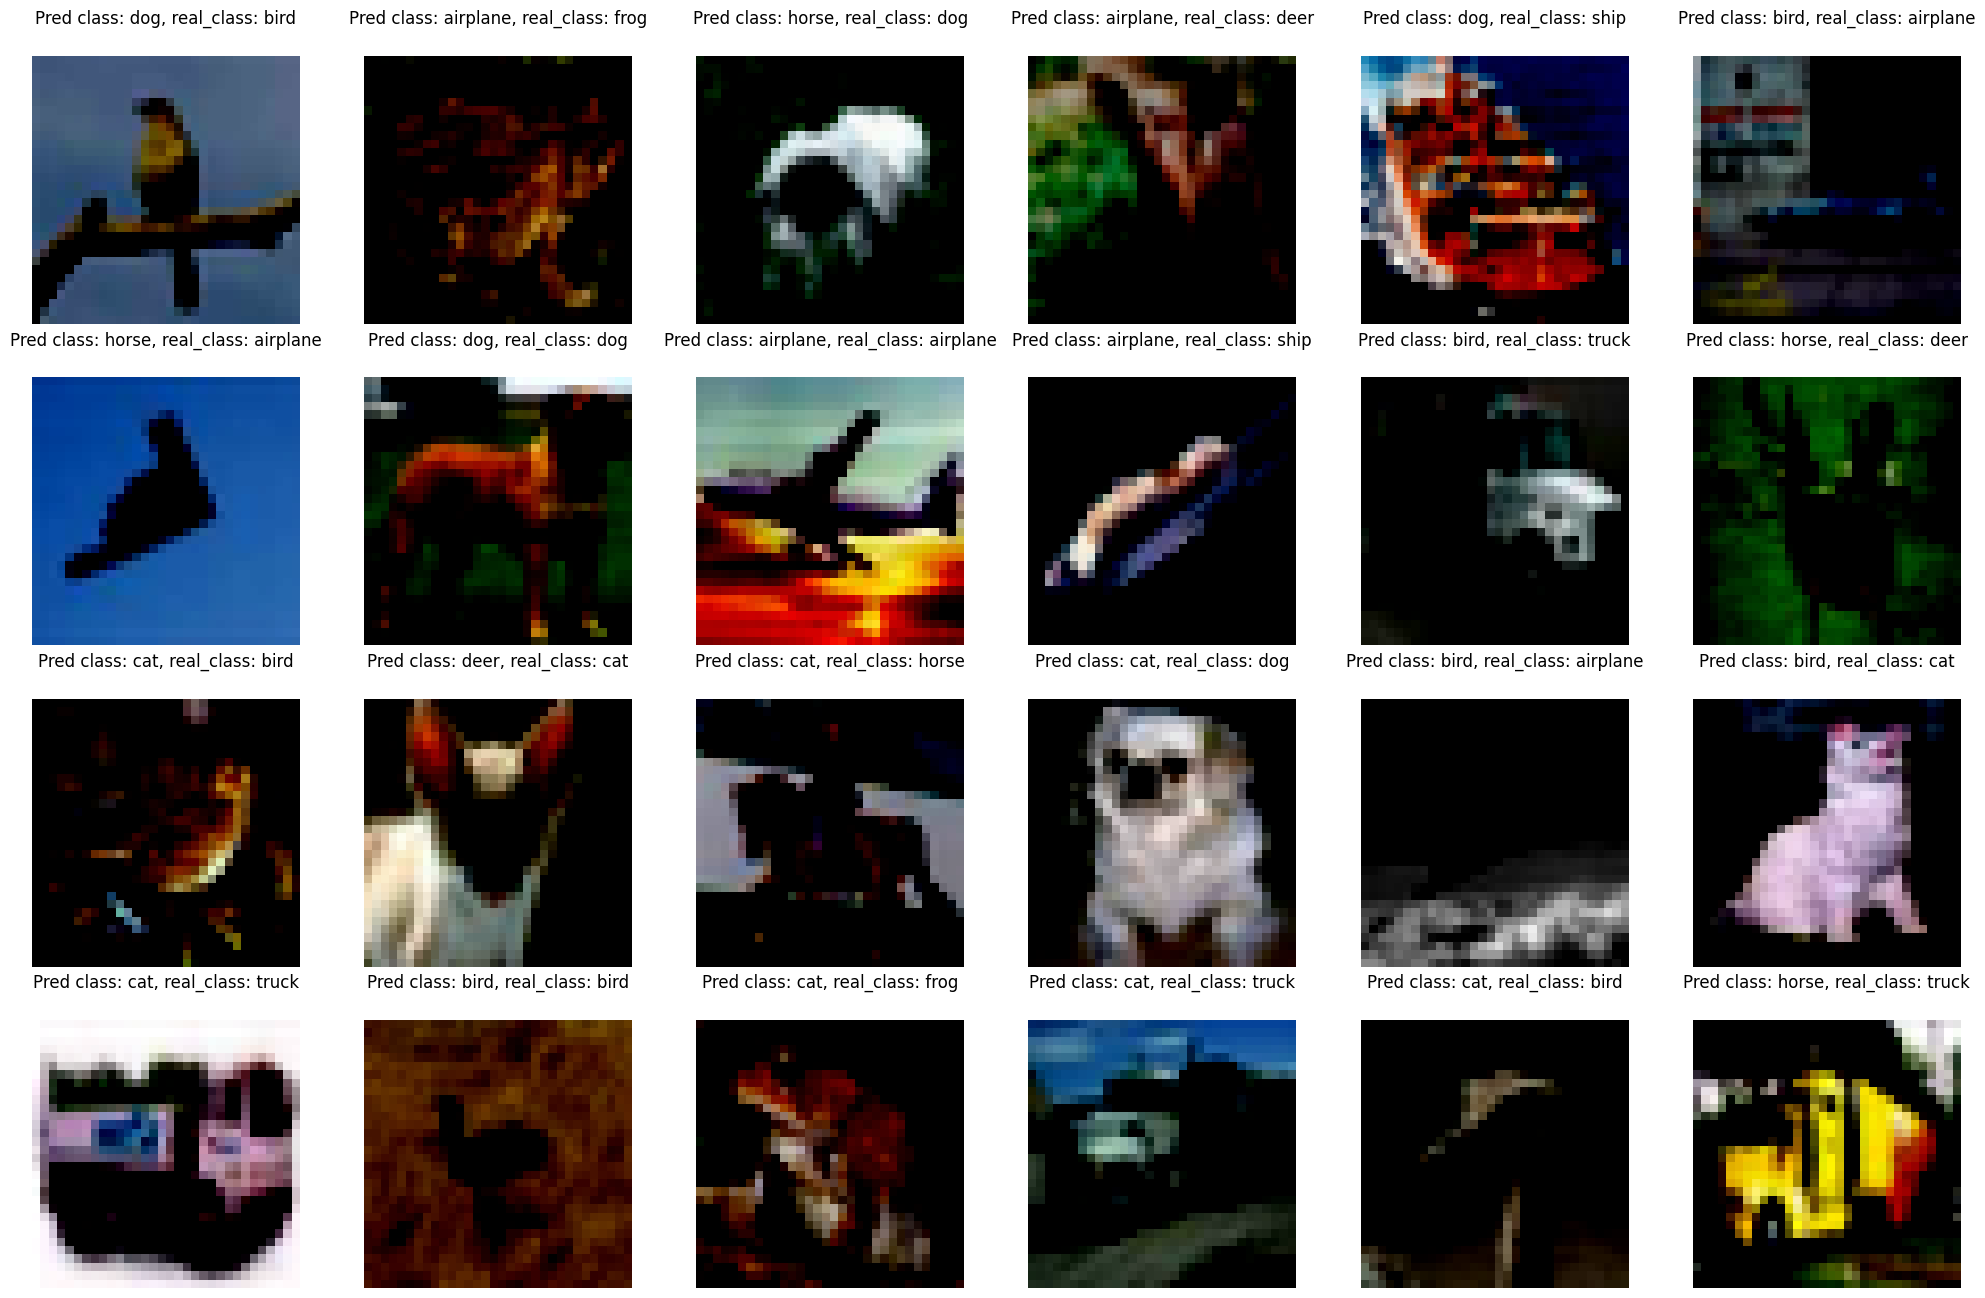

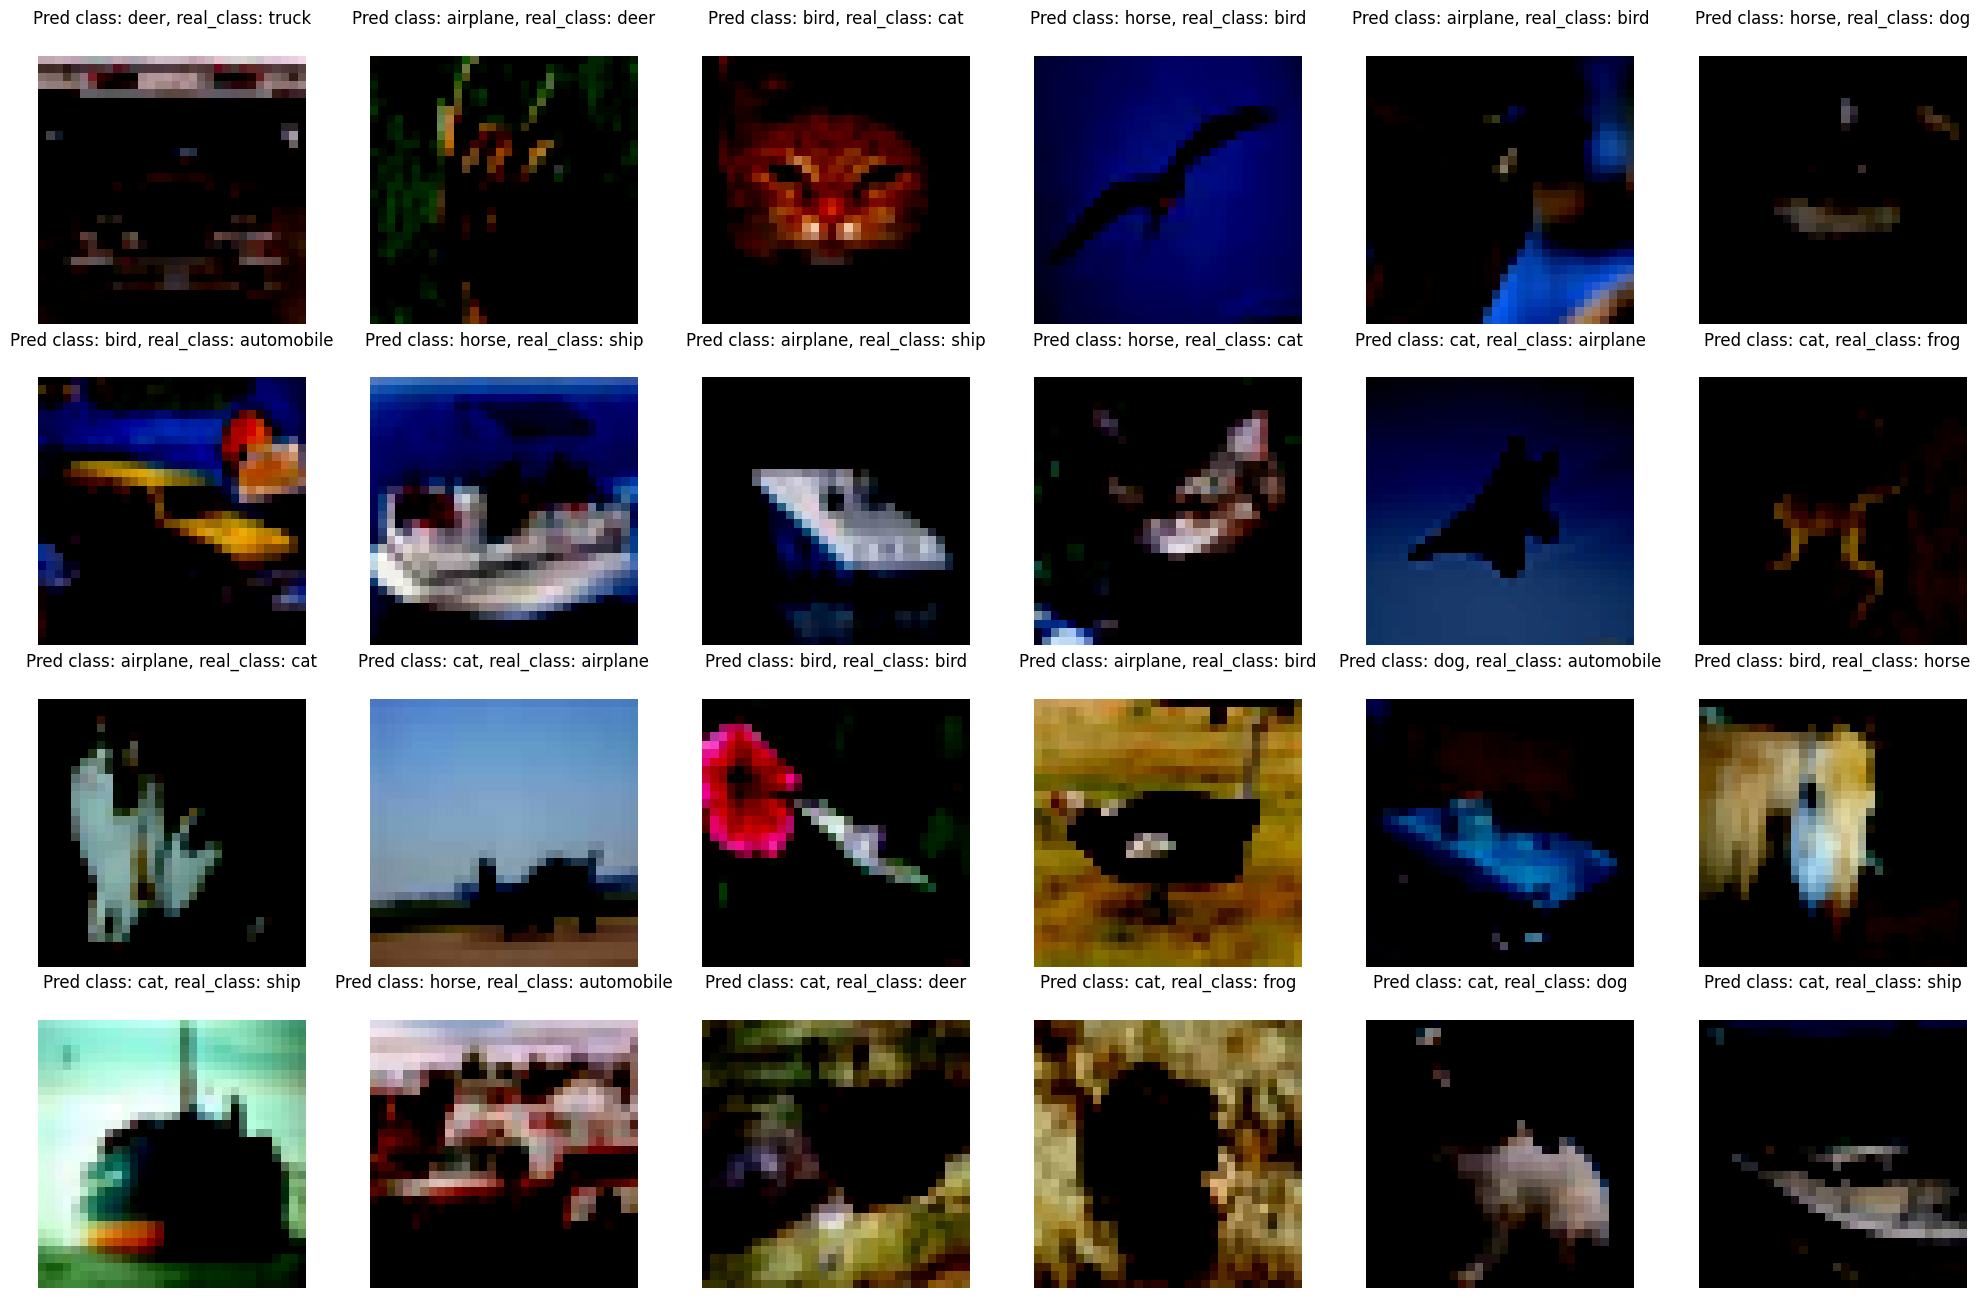

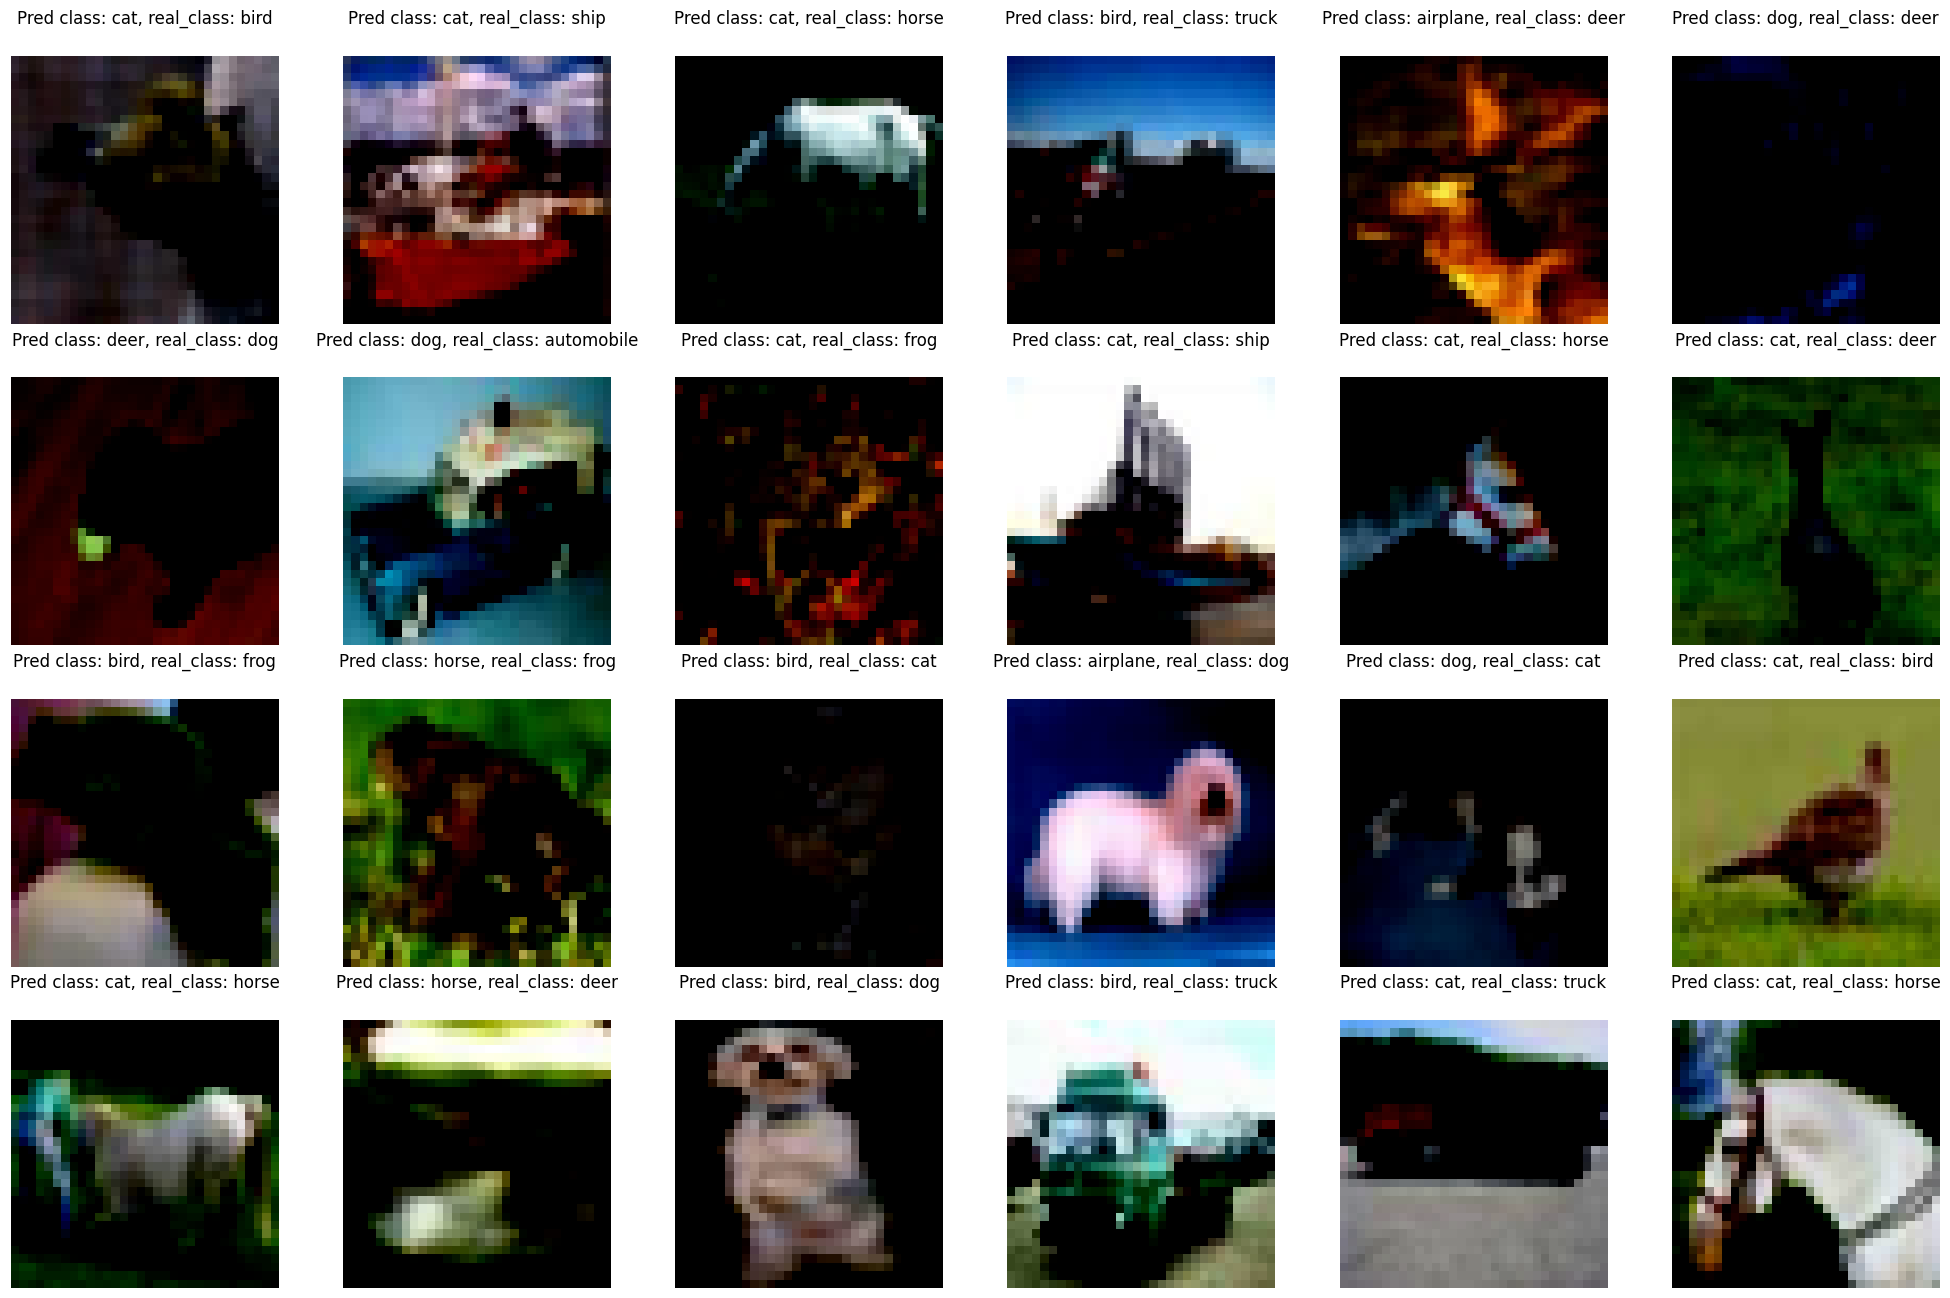

In [12]:
def get_batch_from_loader(loader):
    batch, labels = next(iter(loader))
    return batch, labels
for x in range(0,5):
    get_batch_from_loader(test_loader)
    # распечатаем произвольную картинку
    fig, ax = plt.subplots(4, 6, figsize=(25, 16))
    ax = ax.flatten()
    batch, labels = get_batch_from_loader(test_loader)
    for i, plot in enumerate(ax):
        img = batch[i]
        pred_class = model_big_drop(img.unsqueeze(0)).softmax(dim=1).argmax().item()
        plot.set_title(f'Pred class: {list(valid_dataset.class_to_idx.keys())[list(valid_dataset.class_to_idx.values()).index(pred_class)]}, real_class: {list(valid_dataset.class_to_idx.keys())[list(valid_dataset.class_to_idx.values()).index(labels[i])]}')
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)
        plot.matshow(img[:, :, :])
        plot.axis('off')